In [1]:
project_root = None

# Báo cáo đánh giá mô hình
Notebook này dùng để đánh giá hiệu năng của mô hình học máy đã huấn luyện bằng nhiều chỉ số và biểu đồ khác nhau.


In [ ]:
from pathlib import Path
import sys
import yaml
from sklearn.model_selection import train_test_split

if project_root is None:
    PROJECT_ROOT = Path.cwd().parent
else:
    PROJECT_ROOT = Path(project_root)
    
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

from src.data.cleaner import DataCleaner
from src.data.loader import DataLoader
from src.models.supervised import LogisticModel
from src.evaluation.metrics import classification_metrics
from src.evaluation.report import EvaluationReport
from src.visualization.plots import plot_confusion, plot_attrition_distribution, plot_model_comparison

with open(PROJECT_ROOT / "configs" / "params.yaml") as f:
    cfg = yaml.safe_load(f)

DATA_PATH = PROJECT_ROOT / cfg["paths"]["raw_data"]
TARGET = cfg["target"]


In [3]:
df = DataLoader(DATA_PATH).load()
X, y, _ = DataCleaner().clean(df, target=TARGET)

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=cfg["test_size"],
    random_state=cfg['seed'],
    stratify=y
)

model = LogisticModel(cfg["seed"])
model.train(X_train, y_train)
    
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)

metrics = classification_metrics(y_test, y_pred, y_prob)
metrics


{'Accuracy': 0.9050847457627119,
 'Precision': 0.7714285714285715,
 'Recall': 0.574468085106383,
 'F1': 0.6585365853658537,
 'ROC_AUC': 0.9022820864790667,
 'PR_AUC': 0.75650812198808}

## Báo cáo phân loại (Classification Report)

Bảng này hiển thị các chỉ số đánh giá quan trọng:

- **Precision (Độ chính xác)**: Trong các mẫu được dự đoán là dương, có bao nhiêu mẫu đúng.
- **Recall (Độ bao phủ)**: Trong các mẫu thực sự là dương, mô hình dự đoán đúng được bao nhiêu.
- **F1-score**: Trung bình điều hòa giữa Precision và Recall.

Các chỉ số này giúp đánh giá hiệu năng của mô hình trên từng lớp.


In [4]:
report = EvaluationReport(PROJECT_ROOT / "outputs" / "tables")
report.add_result("Supervised", metrics)
report.save_csv()


'c:\\work-space\\DNU\\part-8\\big-data\\BTL\\pg_al_rf_staff\\outputs\\tables\\evaluation_results.csv'

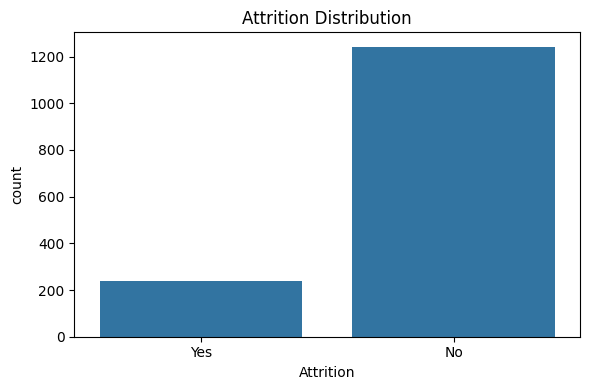

In [5]:
fig_dir = PROJECT_ROOT / "outputs" / "figures"
fig_dir.mkdir(parents=True, exist_ok=True)

plot_attrition_distribution(
    df["Attrition"],
    save_path=fig_dir / "attrition_distribution.png"
)

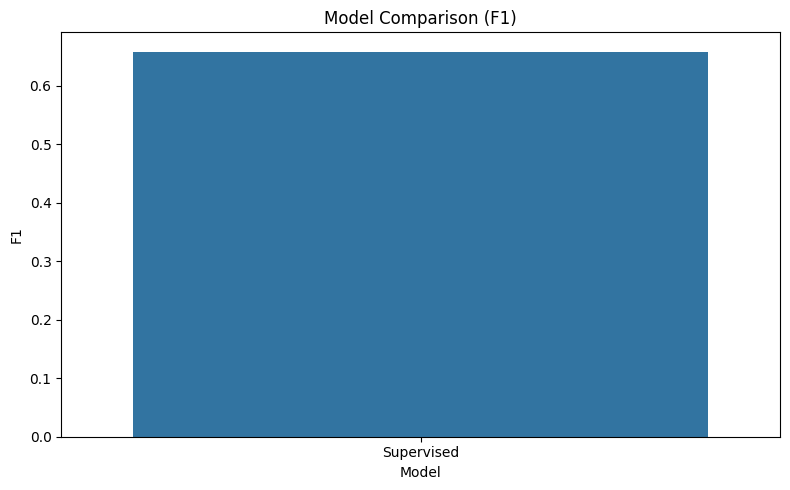

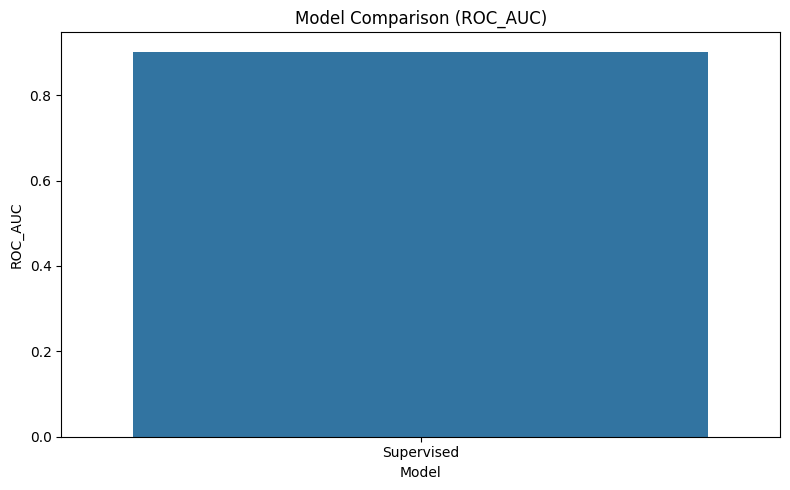

In [6]:
results_df = report.to_dataframe()
results_df

plot_model_comparison(
    results_df,
    metric="F1",
    save_path=fig_dir / "evaluation_model_f1.png"
)

plot_model_comparison(
    results_df,
    metric="ROC_AUC",
    save_path=fig_dir / "evaluation_model_roc_auc.png"
)


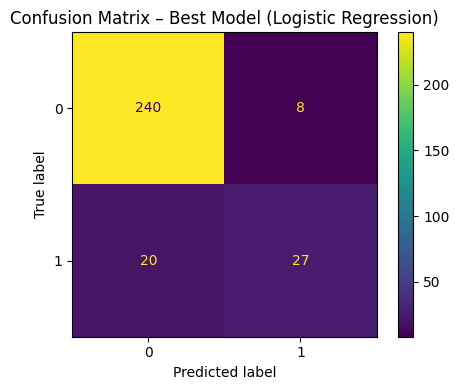

In [7]:
plot_confusion(
    y_test, y_pred,
    save_path=fig_dir / "confusion_matrix_best_model.png",
    title="Confusion Matrix – Best Model (Logistic Regression)"
)


## Ma trận nhầm lẫn (Confusion Matrix)

Ma trận nhầm lẫn cho biết số lượng mẫu được dự đoán đúng và sai.

- True Positive (TP): Dự đoán đúng mẫu thuộc lớp dương.
- True Negative (TN): Dự đoán đúng mẫu thuộc lớp âm.
- False Positive (FP): Dự đoán sai, dự đoán là dương nhưng thực tế là âm.
- False Negative (FN): Dự đoán sai, dự đoán là âm nhưng thực tế là dương.

Ma trận này giúp ta hiểu mô hình đang mắc lỗi ở loại nào.


In [8]:
fp = ((y_test == 0) & (y_pred == 1)).sum()
fn = ((y_test == 1) & (y_pred == 0)).sum()

print("False Positive (dự đoán nghỉ nhưng thực tế không nghỉ):", fp)
print("False Negative (không phát hiện người sẽ nghỉ):", fn)


False Positive (dự đoán nghỉ nhưng thực tế không nghỉ): 8
False Negative (không phát hiện người sẽ nghỉ): 20


## Đường cong ROC

Đường cong ROC thể hiện sự đánh đổi giữa:

- True Positive Rate (TPR) – Tỷ lệ dự đoán đúng lớp dương
- False Positive Rate (FPR) – Tỷ lệ dự đoán nhầm lớp dương

**AUC (Area Under Curve)** là diện tích dưới đường ROC, cho biết khả năng phân biệt giữa các lớp của mô hình.

- AUC = 1.0 → Mô hình hoàn hảo
- AUC > 0.9 → Rất tốt
- AUC > 0.8 → Tốt
- AUC > 0.7 → Chấp nhận được


## Nhận xét về hiệu năng mô hình

Dựa trên các chỉ số đánh giá thu được:

- **Accuracy = 0.905** → Mô hình dự đoán đúng khoảng 90.5% tổng số mẫu, đây là mức khá cao.
- **Precision = 0.771** → Trong các mẫu được dự đoán là lớp dương, khoảng 77.1% là đúng.
- **Recall = 0.574** → Mô hình chỉ phát hiện được khoảng 57.4% các mẫu thực sự thuộc lớp dương. Điều này cho thấy mô hình còn bỏ sót khá nhiều mẫu dương.
- **F1-score = 0.659** → Mức cân bằng giữa Precision và Recall ở mức trung bình.
- **ROC-AUC = 0.903** → Khả năng phân biệt giữa hai lớp của mô hình là rất tốt.

### Phân tích
- Mô hình có **độ chính xác tổng thể cao** và **khả năng phân biệt lớp tốt** (AUC > 0.9).
- Tuy nhiên, **Recall còn thấp**, nghĩa là mô hình chưa phát hiện được nhiều trường hợp thuộc lớp dương.
- Điều này có thể gây ảnh hưởng nếu bài toán yêu cầu phát hiện đầy đủ các trường hợp dương tính.

### Kết luận
- Mô hình Logistic Regression hoạt động khá tốt về tổng thể.
- Tuy nhiên, cần cải thiện **Recall** để tăng khả năng phát hiện lớp dương.